In [1]:
!git clone https://github.com/TUD-STKS/SECAI-Summer-School.git
!pip install SECAI-Summer-School/.[notebook]

Cloning into 'SECAI-Summer-School'...


You should consider upgrading via the 'C:\Users\Steiner\Documents\Python\SECAI-Summer-School\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Processing c:\users\steiner\documents\python\secai-summer-school\secai-summer-school
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for secai-machine-learning-workshop-PETER-STEINER: filename=secai_machine_learning_workshop_PETER_STEINER-0.0.1-py3-none-any.whl size=7671 sha256=921b22c9759ea323184db77c57f6aa604aaf48f6ba879b36c1913571b87b6196
  Stored in directory: c:\users\steiner\appdata\local\pip\cache\wheels\ae\d0\cb\f075657ea3111eaf6e1257dea77e28c7f0d5ed80240713fa10
Successfully built secai-machine-learning-workshop-PETER-STEINER
  Attempting uninstall: secai-machine-learning-workshop-

You should consider upgrading via the 'C:\Users\Steiner\Documents\Python\SECAI-Summer-School\venv\Scripts\python.exe -m pip install --upgrade pip' command.


# Introduction to Machine Learning

- Teilnehmende werden fast kein Python kennen
- Google Colab
- Einführung in Python kurz halten -> evtl. zumindest kurz erklären, was eine Funktion ist
- Regression in sklearn
- Übergang zu PyTorch -> Motivieren, warum PyTorch für komplexere Modelle besser geignet ist
- Englisch!!!

In [2]:
from joblib import dump, load
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import RidgeClassifier
from sklearn.utils.fixes import loguniform

from torch_models import LinearRegression, MultiLayerPerceptron, EarlyStopping

import medmnist
from medmnist import INFO, Evaluator

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
sns.set_theme(context="notebook")

cuda_available = torch.cuda.is_available()
device = torch.device('cuda') if cuda_available else torch.device('cpu')

# We first work on the 2D dataset called "PathMNIST"

The following cell give us some first information about this dataset. We are dealing with an image dataset containing RGB impage patches from hematoxylin & eosin stained histological images, obtained in different clinical centers.

Since we are dealing with RGB image patches, we have three different channels.

In total, there are nine different classes. Hence, we have a multi-class dataset, and each image is assigned to exactly one class.

The training and validation set (NCT-CRC-HE-100K) contain 100,000 patches, and the test set contains 7,180 image patches (CRC-VAL-HE-7K) from a different clinical center.

In [4]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'

info = INFO[data_flag]
task = info['task']
labels = info['label']

n_channels = info['n_channels']
n_classes = len(info['label'])

info

{'python_class': 'PathMNIST',
 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.',
 'url': 'https://zenodo.org/record/6496656/files/pathmnist.npz?download=1',
 'MD5': 'a8b06965200029087d5bd730944a56c1',
 'task': 'multi-class',
 'label': {'0': 'adipose',
  '1': 'background',
  '2': 'debris',
  '3': 'lymphocytes',
  '4': 'mucus',
  '5': 'smooth muscle',
  '6': 'normal colon mucosa',
  '7': 'cancer-associated stroma',
  '8': '

We prepare to download the dataset (if it is not already downloaded) and instantiate

In [5]:
download = True

## First, we read the raw MedMNIST data without any preprocessing

Since we want to dive deeper into the dataset, we do not apply any kind of preprocessing. We only make sure that the dataset class returns the data as `torch.Tensor`, such that we can easily analyze it further.

Note that we create two different datasets, one for training and one for test. This is something that we always need to keep in mind. Always split training and test data and make sure that no test data is used for training or parameter optimization.

In [6]:
BATCH_SIZE = 128
N_PIXELS = 28*28

validation_split = .2

# preprocessing
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=data_transform,
                          download=download)
test_dataset = DataClass(split='test', transform=data_transform,
                         download=download)

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = data.sampler.SubsetRandomSampler(val_indices)

# encapsulate data into dataloader form
cv_train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
cv_validation_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE,
    sampler=valid_sampler)
train_loader = data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(
    dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Steiner\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\Steiner\.medmnist\pathmnist.npz


In [7]:
training_input = []
training_target = []
for data in tqdm(train_loader):
    training_input.append(data[0].numpy().reshape(-1, N_PIXELS))
    training_target.append(data[1].numpy().flatten())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:10<00:00, 66.42it/s]


In [8]:
training_df = pd.DataFrame(np.vstack(training_input), columns=[f"Pixel {k+1}" for k in range(N_PIXELS)])
training_df["Target"] = [labels[str(d)] for d in np.hstack(training_target)]
training_df["Numeric target"] = np.hstack(training_target)

In [9]:
training_df

,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,...,Pixel 777,Pixel 778,Pixel 779,Pixel 780,Pixel 781,Pixel 782,Pixel 783,Pixel 784,Target,Numeric target
0,0.129412,0.709804,0.858824,0.874510,0.615686,-0.066667,-0.137255,-0.105882,-0.200000,-0.121569,...,0.152941,0.090196,0.270588,-0.011765,0.113726,0.207843,0.129412,0.019608,debris,2
1,-0.066667,-0.145098,-0.050980,-0.027451,-0.160784,-0.074510,-0.137255,-0.035294,0.058824,0.011765,...,0.545098,0.043137,-0.074510,0.278431,0.192157,0.333333,0.294118,0.403922,colorectal adenocarcinoma epithelium,8
2,-0.082353,0.058824,0.129412,0.294118,0.035294,-0.035294,-0.074510,-0.050980,-0.082353,0.050980,...,0.890196,0.882353,0.890196,0.890196,0.819608,0.647059,0.286275,0.082353,colorectal adenocarcinoma epithelium,8
3,0.247059,0.278431,0.286275,0.584314,0.560784,0.364706,0.239216,-0.129412,-0.160784,0.160784,...,0.121569,0.231373,0.372549,0.247059,0.200000,0.152941,0.215686,0.207843,mucus,4
4,0.443137,0.396078,0.333333,0.325490,0.286275,0.192157,0.168628,0.200000,0.380392,0.396078,...,0.466667,0.694118,0.678431,0.701961,0.756863,0.592157,0.490196,0.521569,normal colon mucosa,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89991,0.725490,0.725490,0.717647,0.725490,0.725490,0.717647,0.725490,0.725490,0.725490,0.717647,...,0.733333,0.678431,0.474510,0.686275,0.701961,0.709804,0.725490,0.717647,adipose,0
89992,0.882353,0.882353,0.882353,0.882353,0.874510,0.858824,0.850980,0.866667,0.882353,0.882353,...,0.882353,0.890196,0.882353,0.882353,0.882353,0.890196,0.882353,0.882353,smooth muscle,5
89993,0.756863,0.717647,0.639216,0.654902,0.701961,0.717647,0.749020,0.756863,0.701961,0.701961,...,0.458824,0.678431,0.505882,0.435294,0.278431,0.168628,0.396078,0.709804,background,1
89994,0.231373,0.223529,0.286275,0.215686,0.270588,0.301961,0.349020,0.113726,0.058824,0.372549,...,0.129412,0.231373,0.239216,0.160784,0.027451,0.192157,0.364706,0.239216,cancer-associated stroma,7


## Visualization

Visualization is always a crucial part when getting started with a new dataset. Even when only looking on samples, we get a better idea of what is contained in the dataset.

Here, we observe severa interesting things:

- The pixel values (mean of the different RGB values) seem to be normalized, as we do not deal with integer values.
- The value ranges are different. In most of the images, the values seem to lie between 0.3 and 0.8, but not always.
- The histograms indicate that the pixel values overall are distributed reasonable.
- All pixels seem to carry information, as the distribution does not indicate that some pixel values have a small standard deviation.

All in all, this suggests that the pre-processing is simple in case of this dataset. We will simply shift each pixel value by 0.5 and 

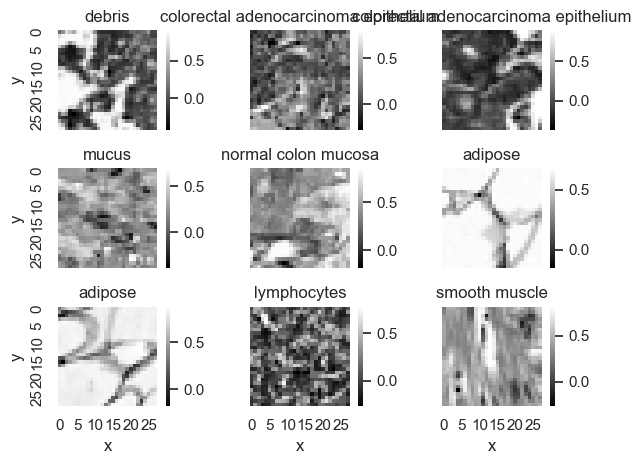

In [10]:
fig, axs = plt.subplots(3, 3, sharex="all", sharey="all")

for k in range(9):
    sns.heatmap(data=training_df.loc[k, [f"Pixel {k+1}" for k in range(N_PIXELS)]].values.astype(float).reshape(28, 28).T,
                ax=axs.flatten()[k], square=True, cmap="gray")
    axs.flatten()[k].set_title(training_df.loc[k, "Target"])

[ax.set_xlabel("x") for ax in axs[-1, :]]
[ax.set_ylabel("y") for ax in axs[:, 0]]
plt.tight_layout()

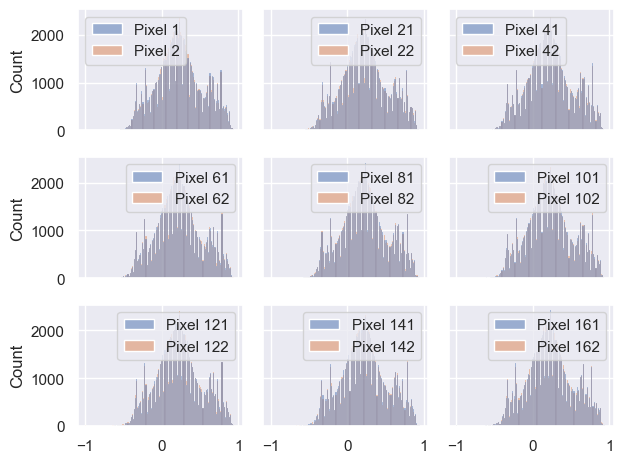

In [11]:
fig, axs = plt.subplots(3, 3, sharex="all", sharey="all")

sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(0, 2)]], ax=axs.flatten()[0])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(20, 22)]], ax=axs.flatten()[1])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(40, 42)]], ax=axs.flatten()[2])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(60, 62)]], ax=axs.flatten()[3])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(80, 82)]], ax=axs.flatten()[4])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(100, 102)]], ax=axs.flatten()[5])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(120, 122)]], ax=axs.flatten()[6])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(140, 142)]], ax=axs.flatten()[7])
sns.histplot(data=training_df.loc[:, [f"Pixel {k+1}" for k in range(160, 162)]], ax=axs.flatten()[8])

plt.tight_layout()

In [12]:
pca = PCA().fit(training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]])

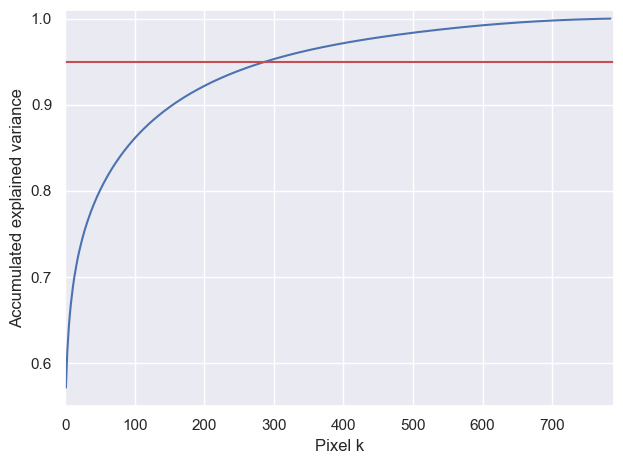

In [13]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, 785), y=np.cumsum(pca.explained_variance_ratio_), ax=axs)
axs.axhline(y=0.95, c="r")
axs.set_xlabel("Pixel k")
axs.set_ylabel("Accumulated explained variance")
axs.set_xlim((0, N_PIXELS+5))
axs.set_ylim((0.55, 1.01))
plt.tight_layout()

In [14]:
try:
    clf = load("results/sklearn_linear_model.joblib")
except FileNotFoundError:
    clf = RandomizedSearchCV(estimator=RidgeClassifier(loss="log_loss"), n_iter=50,
                             n_jobs=6, cv=3, verbose=10,
                             param_distributions={"alpha": loguniform(a=1e-5, b=1e1)}).fit(
        training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]], y=training_df.loc[:, "Numeric target"])
    dump(clf, "results/sklearn_linear_model.joblib")

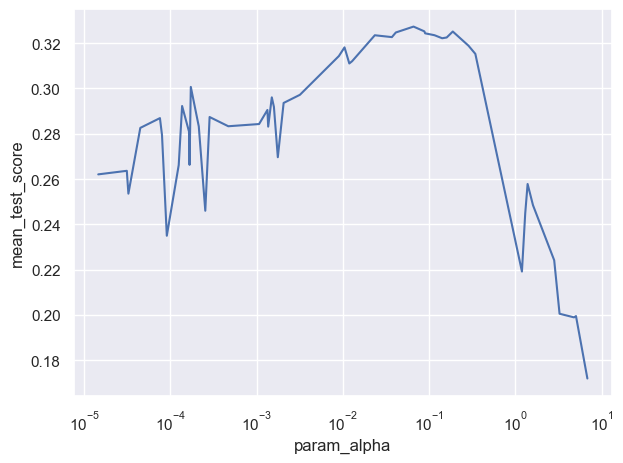

In [15]:
fig, axs = plt.subplots()

sns.lineplot(data=pd.DataFrame(clf.cv_results_), x="param_alpha", y="mean_test_score", ax=axs)
plt.xscale("log")
plt.tight_layout()

In [16]:
clf.score(training_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]],
          y=training_df.loc[:, "Numeric target"])

0.3303369038623939

In [17]:
test_input = []
test_target = []
for data in tqdm(test_loader):
    test_input.append(data[0].numpy().reshape(-1, N_PIXELS))
    test_target.append(data[1].numpy().flatten())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.53it/s]


In [18]:
test_df = pd.DataFrame(np.vstack(test_input), columns=[f"Pixel {k+1}" for k in range(N_PIXELS)])
test_df["Target"] = [labels[str(d)] for d in np.hstack(test_target)]
test_df["Numeric target"] = np.hstack(test_target)

In [19]:
clf.score(test_df.loc[:, [f"Pixel {k+1}" for k in range(N_PIXELS)]], y=test_df.loc[:, "Numeric target"])

0.44220055710306405

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [21]:
def train_validate_model(model, patience, n_epochs, path, training_dataloader, validation_dataloader):
    # to track the training loss as the model trains
    training_losses = []
    # to track the validation loss as the model trains
    validation_losses = []
    # to track the average training loss per epoch as the model trains
    average_training_losses = []
    # to track the average validation loss per epoch as the model trains
    average_validation_losses = [] 
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=path)
    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(training_dataloader, 1):
            data = data.to(device)
            target = target.to_device()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            training_losses.append(loss.item())
        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in validation_dataloader:
            data = data.to(device)
            target = target.to_device()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # record validation loss
            validation_losses.append(loss.item())
        # print training/validation statistics 
        # calculate average loss over an epoch
        training_loss = np.average(training_losses)
        validation_loss = np.average(validation_losses)
        average_training_losses.append(training_loss)
        average_validation_losses.append(validation_loss)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] '
                     f'train_loss: {training_loss:.5f} '
                     f'valid_loss: {validation_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(validation_loss, model, optimizer, epoch)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    return  model, optimizer, early_stopping.epoch, loss, average_training_losses, average_validation_losses

In [22]:
def train_model(model, n_epochs, path, training_dataloader):
    # to track the training loss as the model trains
    training_losses = []
    # to track the average training loss per epoch as the model trains
    average_training_losses = []
    for epoch in range(1, n_epochs + 1):
        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(training_dataloader, 1):
            data = data.to(device)
            target = target.to_device()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            target = target.squeeze().long()
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            training_losses.append(loss.item())
        # print training/validation statistics 
        # calculate average loss over an epoch
        training_loss = np.average(training_losses)
        average_training_losses.append(training_loss)
        epoch_len = len(str(n_epochs))
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] '
                     f'train_loss: {training_loss:.5f}')
        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),},
               path)
    return model, optimizer, epoch, loss, average_training_losses

In [23]:
model = LinearRegression(in_features=784, num_classes=n_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

In [24]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 5
num_epochs = 500
model, optimizer, epoch, loss, average_training_losses, average_validation_losses = train_validate_model(
    model, patience, num_epochs, "results/torch_linear_model.pt", cv_train_loader, cv_validation_loader)

[  1/500] train_loss: 2.08997 valid_loss: 2.07399
Validation loss decreased (inf --> 2.073992).  Saving model ...
[  2/500] train_loss: 2.06730 valid_loss: 2.05751
Validation loss decreased (2.073992 --> 2.057509).  Saving model ...
[  3/500] train_loss: 2.05073 valid_loss: 2.04509
Validation loss decreased (2.057509 --> 2.045093).  Saving model ...
[  4/500] train_loss: 2.03805 valid_loss: 2.03559
Validation loss decreased (2.045093 --> 2.035591).  Saving model ...
[  5/500] train_loss: 2.02797 valid_loss: 2.02822
Validation loss decreased (2.035591 --> 2.028225).  Saving model ...
[  6/500] train_loss: 2.01976 valid_loss: 2.02197
Validation loss decreased (2.028225 --> 2.021969).  Saving model ...
[  7/500] train_loss: 2.01292 valid_loss: 2.01670
Validation loss decreased (2.021969 --> 2.016700).  Saving model ...
[  8/500] train_loss: 2.00714 valid_loss: 2.01235
Validation loss decreased (2.016700 --> 2.012345).  Saving model ...
[  9/500] train_loss: 2.00217 valid_loss: 2.00847
Val

[ 70/500] train_loss: 1.94974 valid_loss: 1.96959
Validation loss decreased (1.969688 --> 1.969588).  Saving model ...
[ 71/500] train_loss: 1.94959 valid_loss: 1.96948
Validation loss decreased (1.969588 --> 1.969478).  Saving model ...
[ 72/500] train_loss: 1.94945 valid_loss: 1.96939
Validation loss decreased (1.969478 --> 1.969388).  Saving model ...
[ 73/500] train_loss: 1.94931 valid_loss: 1.96930
Validation loss decreased (1.969388 --> 1.969303).  Saving model ...
[ 74/500] train_loss: 1.94918 valid_loss: 1.96921
Validation loss decreased (1.969303 --> 1.969209).  Saving model ...
[ 75/500] train_loss: 1.94904 valid_loss: 1.96912
Validation loss decreased (1.969209 --> 1.969124).  Saving model ...
[ 76/500] train_loss: 1.94891 valid_loss: 1.96903
Validation loss decreased (1.969124 --> 1.969027).  Saving model ...
[ 77/500] train_loss: 1.94879 valid_loss: 1.96894
Validation loss decreased (1.969027 --> 1.968944).  Saving model ...
[ 78/500] train_loss: 1.94867 valid_loss: 1.9688

[140/500] train_loss: 1.94453 valid_loss: 1.96605
Validation loss decreased (1.966073 --> 1.966048).  Saving model ...
[141/500] train_loss: 1.94449 valid_loss: 1.96602
Validation loss decreased (1.966048 --> 1.966019).  Saving model ...
[142/500] train_loss: 1.94446 valid_loss: 1.96599
Validation loss decreased (1.966019 --> 1.965986).  Saving model ...
[143/500] train_loss: 1.94442 valid_loss: 1.96596
Validation loss decreased (1.965986 --> 1.965959).  Saving model ...
[144/500] train_loss: 1.94438 valid_loss: 1.96593
Validation loss decreased (1.965959 --> 1.965935).  Saving model ...
[145/500] train_loss: 1.94435 valid_loss: 1.96591
Validation loss decreased (1.965935 --> 1.965906).  Saving model ...
[146/500] train_loss: 1.94431 valid_loss: 1.96588
Validation loss decreased (1.965906 --> 1.965883).  Saving model ...
[147/500] train_loss: 1.94428 valid_loss: 1.96586
Validation loss decreased (1.965883 --> 1.965856).  Saving model ...
[148/500] train_loss: 1.94425 valid_loss: 1.9658

[210/500] train_loss: 1.94279 valid_loss: 1.96478
Validation loss decreased (1.964795 --> 1.964782).  Saving model ...
[211/500] train_loss: 1.94277 valid_loss: 1.96477
Validation loss decreased (1.964782 --> 1.964769).  Saving model ...
[212/500] train_loss: 1.94276 valid_loss: 1.96476
Validation loss decreased (1.964769 --> 1.964757).  Saving model ...
[213/500] train_loss: 1.94274 valid_loss: 1.96476
EarlyStopping counter: 1 out of 5
[214/500] train_loss: 1.94273 valid_loss: 1.96476
EarlyStopping counter: 2 out of 5
[215/500] train_loss: 1.94271 valid_loss: 1.96474
Validation loss decreased (1.964757 --> 1.964742).  Saving model ...
[216/500] train_loss: 1.94269 valid_loss: 1.96474
Validation loss decreased (1.964742 --> 1.964735).  Saving model ...
[217/500] train_loss: 1.94268 valid_loss: 1.96472
Validation loss decreased (1.964735 --> 1.964722).  Saving model ...
[218/500] train_loss: 1.94266 valid_loss: 1.96471
Validation loss decreased (1.964722 --> 1.964706).  Saving model ...

[281/500] train_loss: 1.94192 valid_loss: 1.96417
Validation loss decreased (1.964174 --> 1.964172).  Saving model ...
[282/500] train_loss: 1.94191 valid_loss: 1.96417
Validation loss decreased (1.964172 --> 1.964165).  Saving model ...
[283/500] train_loss: 1.94190 valid_loss: 1.96416
Validation loss decreased (1.964165 --> 1.964158).  Saving model ...
[284/500] train_loss: 1.94189 valid_loss: 1.96416
EarlyStopping counter: 1 out of 5
[285/500] train_loss: 1.94188 valid_loss: 1.96415
Validation loss decreased (1.964158 --> 1.964153).  Saving model ...
[286/500] train_loss: 1.94187 valid_loss: 1.96415
Validation loss decreased (1.964153 --> 1.964145).  Saving model ...
[287/500] train_loss: 1.94186 valid_loss: 1.96414
Validation loss decreased (1.964145 --> 1.964140).  Saving model ...
[288/500] train_loss: 1.94185 valid_loss: 1.96414
Validation loss decreased (1.964140 --> 1.964139).  Saving model ...
[289/500] train_loss: 1.94185 valid_loss: 1.96413
Validation loss decreased (1.9641

[353/500] train_loss: 1.94139 valid_loss: 1.96386
Validation loss decreased (1.963869 --> 1.963863).  Saving model ...
[354/500] train_loss: 1.94138 valid_loss: 1.96386
Validation loss decreased (1.963863 --> 1.963859).  Saving model ...
[355/500] train_loss: 1.94137 valid_loss: 1.96385
Validation loss decreased (1.963859 --> 1.963854).  Saving model ...
[356/500] train_loss: 1.94137 valid_loss: 1.96385
Validation loss decreased (1.963854 --> 1.963848).  Saving model ...
[357/500] train_loss: 1.94136 valid_loss: 1.96384
Validation loss decreased (1.963848 --> 1.963841).  Saving model ...
[358/500] train_loss: 1.94136 valid_loss: 1.96384
Validation loss decreased (1.963841 --> 1.963838).  Saving model ...
[359/500] train_loss: 1.94135 valid_loss: 1.96383
Validation loss decreased (1.963838 --> 1.963832).  Saving model ...
[360/500] train_loss: 1.94135 valid_loss: 1.96383
Validation loss decreased (1.963832 --> 1.963826).  Saving model ...
[361/500] train_loss: 1.94134 valid_loss: 1.9638

[425/500] train_loss: 1.94104 valid_loss: 1.96362
Validation loss decreased (1.963626 --> 1.963623).  Saving model ...
[426/500] train_loss: 1.94104 valid_loss: 1.96362
Validation loss decreased (1.963623 --> 1.963623).  Saving model ...
[427/500] train_loss: 1.94103 valid_loss: 1.96362
Validation loss decreased (1.963623 --> 1.963618).  Saving model ...
[428/500] train_loss: 1.94103 valid_loss: 1.96362
Validation loss decreased (1.963618 --> 1.963616).  Saving model ...
[429/500] train_loss: 1.94102 valid_loss: 1.96362
Validation loss decreased (1.963616 --> 1.963615).  Saving model ...
[430/500] train_loss: 1.94102 valid_loss: 1.96361
Validation loss decreased (1.963615 --> 1.963611).  Saving model ...
[431/500] train_loss: 1.94102 valid_loss: 1.96361
Validation loss decreased (1.963611 --> 1.963609).  Saving model ...
[432/500] train_loss: 1.94101 valid_loss: 1.96360
Validation loss decreased (1.963609 --> 1.963603).  Saving model ...
[433/500] train_loss: 1.94101 valid_loss: 1.9636

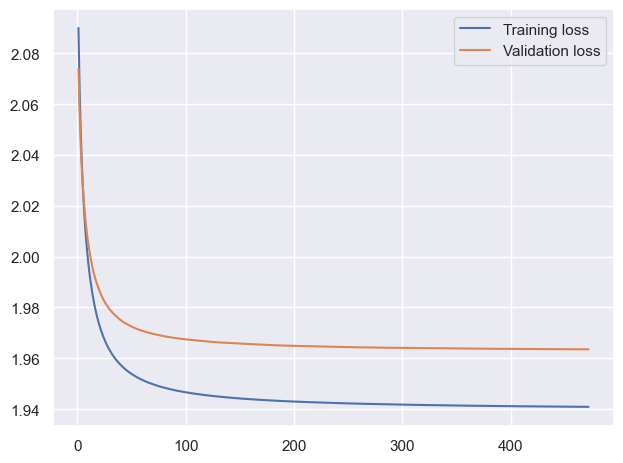

In [26]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, len(average_training_losses) + 1), y=average_training_losses, ax=axs, label="Training loss")
sns.lineplot(x=np.arange(1, len(average_validation_losses) + 1), y=average_validation_losses, ax=axs, label="Validation loss")
plt.tight_layout()

In [29]:
if torch.cuda().is_available()
model = LinearRegression(in_features=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

train_model(model, epoch, "results/torch_linear_model_final.pt", train_loader)

[  1/467] train_loss: 2.08714
[  2/467] train_loss: 2.06153
[  3/467] train_loss: 2.04414
[  4/467] train_loss: 2.03126
[  5/467] train_loss: 2.02139
[  6/467] train_loss: 2.01339
[  7/467] train_loss: 2.00678
[  8/467] train_loss: 2.00127
[  9/467] train_loss: 1.99670
[ 10/467] train_loss: 1.99270
[ 11/467] train_loss: 1.98927
[ 12/467] train_loss: 1.98628
[ 13/467] train_loss: 1.98362
[ 14/467] train_loss: 1.98122
[ 15/467] train_loss: 1.97906
[ 16/467] train_loss: 1.97712
[ 17/467] train_loss: 1.97536
[ 18/467] train_loss: 1.97378
[ 19/467] train_loss: 1.97236
[ 20/467] train_loss: 1.97103
[ 21/467] train_loss: 1.96981
[ 22/467] train_loss: 1.96871
[ 23/467] train_loss: 1.96767
[ 24/467] train_loss: 1.96672
[ 25/467] train_loss: 1.96584
[ 26/467] train_loss: 1.96504
[ 27/467] train_loss: 1.96429
[ 28/467] train_loss: 1.96359
[ 29/467] train_loss: 1.96291
[ 30/467] train_loss: 1.96230
[ 31/467] train_loss: 1.96172
[ 32/467] train_loss: 1.96116
[ 33/467] train_loss: 1.96062
[ 34/467] 

[275/467] train_loss: 1.94549
[276/467] train_loss: 1.94548
[277/467] train_loss: 1.94547
[278/467] train_loss: 1.94546
[279/467] train_loss: 1.94546
[280/467] train_loss: 1.94545
[281/467] train_loss: 1.94544
[282/467] train_loss: 1.94543
[283/467] train_loss: 1.94543
[284/467] train_loss: 1.94542
[285/467] train_loss: 1.94542
[286/467] train_loss: 1.94541
[287/467] train_loss: 1.94540
[288/467] train_loss: 1.94539
[289/467] train_loss: 1.94539
[290/467] train_loss: 1.94538
[291/467] train_loss: 1.94537
[292/467] train_loss: 1.94536
[293/467] train_loss: 1.94536
[294/467] train_loss: 1.94535
[295/467] train_loss: 1.94534
[296/467] train_loss: 1.94533
[297/467] train_loss: 1.94533
[298/467] train_loss: 1.94532
[299/467] train_loss: 1.94532
[300/467] train_loss: 1.94531
[301/467] train_loss: 1.94530
[302/467] train_loss: 1.94530
[303/467] train_loss: 1.94529
[304/467] train_loss: 1.94529
[305/467] train_loss: 1.94528
[306/467] train_loss: 1.94527
[307/467] train_loss: 1.94527
[308/467] 

(LinearRegression(
   (linear_layer): Linear(in_features=784, out_features=9, bias=True)
 ),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0.01
 ),
 467,
 tensor(2.0283, grad_fn=<NllLossBackward0>),
 [2.087136680937626,
  2.0615304986184295,
  2.0441358009296837,
  2.03125639911741,
  2.021385346793316,
  2.013394912563716,
  2.006783597969583,
  2.001265360804444,
  1.99669625359879,
  1.992703169533475,
  1.989272586970536,
  1.9862837894311682,
  1.9836150800770187,
  1.9812172873598801,
  1.9790573888655865,
  1.9771187980553473,
  1.9753570300950245,
  1.973776381481627,
  1.9723640415264945,
  1.9710325688716364,
  1.9698139530046161,
  1.9687093351005522,
  1.9676702673300335,
  1.9667193792040714,
  1.9658446221934123,
  1.9650404282057514,
  1.9642939088734412,
  1.963590647130237,
  1.962912214084946,
  1.962303746796467,
  1.9617165599094808

In [30]:
class MultiLayerPerceptron(nn.Module):
    """
    Train a multilayer perceptron model using PyTorch.

    This class passes the input data through an arbitrary number of hidden
    layers and always puts an activation function in between.

    The first hidden layer size needs to be the number of inputs.

    Parameters
    ----------
    hidden_layer_sizes : tuple[int, ...]
        Sizes of the different hidden layers, starting from the input size.
    num_classes : int
        Number of classes, i.e., number of outputs.
    """
    def __init__(self, hidden_layer_sizes: tuple[int, ...], num_classes: int,
                 non_linearity: nn.Module = nn.ReLU()):
        super(MultiLayerPerceptron, self).__init__()

        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for in_features, out_features in pairwise(hidden_layer_sizes):
            self.hidden_layers.append(nn.Linear(in_features, out_features))

        # Output layer
        self.output_layer = nn.Linear(hidden_layer_sizes[-1], num_classes)
        self.non_linearity = non_linearity

    def forward(self, x):
        """
        Forward function of the model.

        Parameters
        ----------
        x : torch.Tensor, shape=(batch_size, in_features)
            The input data.

        Returns
        -------
        x : torch.Tensor, shape=(batch_size, n_classes)
            The output data (non-linearly transformed input data) that
            approximates the target output.
        """
        x = x.reshape(x.shape[0], -1)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.non_linearity(x)
        x = self.non_linearity(self.output_layer(x))
        return x


model = MultiLayerPerceptron(hidden_layer_sizes=(784, ), num_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

NameError: name 'pairwise' is not defined

In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
num_epochs = 500
model, optimizer, epoch, loss, average_training_losses, average_validation_losses = train_validate_model(
    model, patience, num_epochs, "results/torch_mlp_model.pt", cv_train_loader, cv_validation_loader)

In [ ]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, epoch+1), y=average_training_losses, ax=axs, label="Training loss")
sns.lineplot(x=np.arange(1, epoch+1), y=average_validation_losses, ax=axs, label="Validation loss")
plt.tight_layout()

In [ ]:
model = MultilayerPerceptron(in_features=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

train_model(model, epoch, "results/torch_mlp_model_final.pt", train_loader)

In [ ]:
model = MultiLayerPerceptron(hidden_layer_sizes=(784, 1024, ), num_classes=n_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

In [ ]:
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
num_epochs = 500
model, optimizer, epoch, loss, average_training_losses, average_validation_losses = train_validate_model(
    model, patience, num_epochs, "results/torch_deep_mlp_model.pt", cv_train_loader, cv_validation_loader)

In [ ]:
fig, axs = plt.subplots()

sns.lineplot(x=np.arange(1, epoch+1), y=average_training_losses, ax=axs, label="Training loss")
sns.lineplot(x=np.arange(1, epoch+1), y=average_validation_losses, ax=axs, label="Validation loss")
plt.tight_layout()

In [ ]:
model = DeepMultilayerPerceptron(n_pixels=784, num_classes=n_classes)    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, weight_decay=1e-2)

train_model(model, epoch, "results/torch_deep_mlp_model_final.pt", train_loader)

In [32]:
model = LinearRegression(n_pixels=784, num_classes=n_classes)
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2)

checkpoint = torch.load("torch_linear_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

LinearRegression(
  (linear_layer): Linear(in_features=784, out_features=9, bias=True)
)

In [33]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in tqdm(train_loader):
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
            targets = targets.float().resize_(len(targets), 1)

        y_true.append(targets.detach().numpy().flatten())
        y_pred.append(outputs.detach().numpy().argmax(axis=1))
accuracy_score(np.hstack(y_true), np.hstack(y_pred))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:11<00:00, 61.10it/s]


0.3057802569003067

In [34]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
        else:
            targets = targets.squeeze().long()
            targets = targets.float().resize_(len(targets), 1)

        y_true.append(targets.detach().numpy().flatten())
        y_pred.append(outputs.detach().numpy().argmax(axis=1))
accuracy_score(np.hstack(y_true), np.hstack(y_pred))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.96it/s]


0.42270194986072424

In [32]:
# define a simple CNN model

NUM_EPOCHS = 3
lr = 0.001

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        print(f"I am the input and have the dimensions {x.size()}"
              f" (batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer1(x)
        """
        print(f"I am the output of the first convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer2(x)
        print(f"I am the output of the second convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer3(x)
        print(f"I am the output of the third convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer4(x)
        print(f"I am the output of the fourth convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = self.layer5(x)
        print(f"I am the output of the fifth convolutional layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        x = x.view(x.size(0), -1)
        print(f"I am the new view of the previous output and"
              f" have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        print(f"I am furthermore the input of the final linear "
              f"layer.")
        x = self.fc(x)
        print(f"I am the output of the final linear layer"
              f" and have the dimensions {x.size()}"
              f"(batch_size, num_channels, x_pixels, y_pixels)")
        """
        return x

model = Net(in_channels=n_channels, num_classes=n_classes)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [21]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        break
    break

  0%|                                                                                                                                                                | 0/704 [00:00<?, ?it/s]

I am the input and have the dimensions torch.Size([128, 3, 28, 28]) (batch_size, num_channels, x_pixels, y_pixels)


  0%|                                                                                                                                                                | 0/704 [00:00<?, ?it/s]


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of dimension: 1

In [27]:
?nn.BatchNorm2d

In [26]:
# train
model.train()

losses = []
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
    losses.append(float(loss.detach()))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 704/704 [00:15<00:00, 44.71it/s]


In [27]:
torch.save({'epoch': NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, "torch_linear_model.pt")

In [10]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.979  acc:0.752
test  auc: 0.947  acc:0.619


# We then check a 3D dataset

In [11]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train',  download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32657407/32657407 [00:08<00:00, 3711033.51it/s]


In [12]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [13]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [14]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

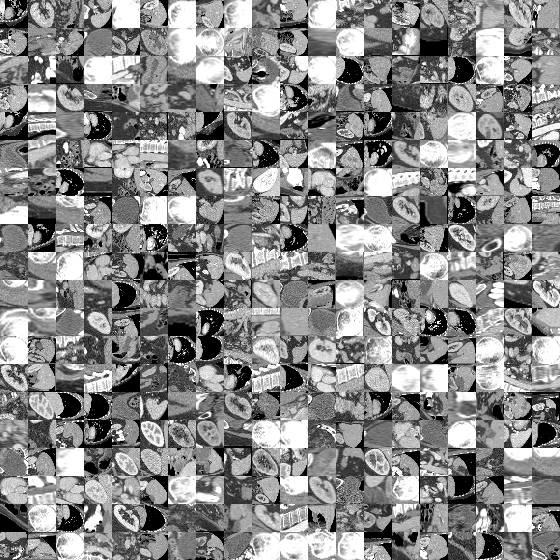

In [15]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]